In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pandas_profiling as pdp
import os
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from pyclustering.cluster import gmeans, xmeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn import metrics
import itertools
import math
import ipyparallel as ipp
from multiprocessing import cpu_count,Pool

import sys
sys.path.append("c:\\Users\\xxp2p\\anaconda3\\envs\\yt_38\\lib\\site-packages\\stock_tools-0.0.1.dev87+g9d6a29c.d20230223-py3.8.egg\\stock_tools\\")
# sys.path.append(r"C:/Users/ryota/sys_trading/stock_tools/src/stock_tools/")
import add_technical, trading_def

COST = 4 / 10000

import ta

def preproces_plusdata(df):
    code = df["CODE"].unique()[0]
    if code <= 2:
        df = df.rename(columns={"Unnamed: 0":"DATE"})
    df[["MARKET","SEC"]] = df[["MARKET","SEC"]].fillna(method="bfill")
    df["DATE"] = pd.to_datetime(df["DATE"])  
    df = df.set_index("DATE")
    return df

def add_stop_factor(df,limit):
    """
    2020年8月3日より4倍値幅は2営業日連続寄らずにストップが行われた翌営業から
    それ以前は、3営業日
    """
    # s高安張り付き判定(値幅拡大前)
    df["stop_limit"] = df["CLOSE"].apply(
        lambda x : limit.loc[np.sum(limit["価格帯"] <= x),"値幅上下限"]
    ).shift()
    df["is_stop_low"] = df.LOW == df.CLOSE.shift() - df["stop_limit"]
    df["is_stop_low_alltime"] = (df.HIGH == df.CLOSE.shift() - df["stop_limit"]) & (df.LOW == df.CLOSE.shift() - df["stop_limit"])
    df["is_stop_high"] = df.LOW == df.CLOSE.shift() + df["stop_limit"]
    df["is_stop_high_alltime"] = (df.HIGH == df.CLOSE.shift() + df["stop_limit"]) & (df.LOW == df.CLOSE.shift() + df["stop_limit"])
    return df

# rankの評価関数
# https://www.szdrblog.info/entry/2017/02/24/235539
def ndcg(y_true, y_pred, k=None, powered=False):
    def dcg(scores, k=None, powered=False):
        if k is None:
            k = scores.shape[0]
        if not powered:
            ret = scores[0]
            for i in range(1, k):
                ret += scores[i] / np.log2(i + 1)
            return ret
        else:
            ret = 0
            for i in range(k):
                ret += (2 ** scores[i] - 1) / np.log2(i + 2)
            return ret
    
    ideal_sorted_scores = np.sort(y_true)[::-1]
    ideal_dcg_score = dcg(ideal_sorted_scores, k=k, powered=powered)
    
    pred_sorted_ind = np.argsort(y_pred)[::-1]
    pred_sorted_scores = y_true[pred_sorted_ind]
    dcg_score = dcg(pred_sorted_scores, k=k, powered=powered)
    
    return dcg_score / ideal_dcg_score

def ndcg1(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=False)

def ndcg2(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=True)

%reload_ext autoreload
%autoreload 2

In [5]:
import os
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import jquantsapi
import json
from visualization import visualization as vi

# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [6]:
import inspect
print(inspect.getsource(vi))

class visualization:
    def __init__(self):
        """ """

    def chart(self, df, technical_list=[], oscillator_list=[]):
        """
        チャートとオシレーターを表示する
        :param df 株価のdataframe
        :param technical_list:list of str  表示したいテクニカルのcolumnsリスト
        :param oscillator_list:list of str  表示したいオシレーターのcolumnsリスト
        :return チャート
        """
        # jpxのdateカラムはDateのため変換
        if "date" not in df.columns:
            df = df.rename(
                columns={
                    f"Adjustment{c}": f"fix_{c.lower()}"
                    for c in ["Open", "High", "Low", "Close"]
                }
            )
            df = df.rename(columns={"Date": "date", "Code": "CODE"})
        code = df["CODE"].iloc[0]
        # subplotsで複数のグラフ画面を作成する
        if len(oscillator_list) != 0:
            heights_list = np.ones(1 + len(oscillator_list))  # row_heightsグラフ高さ倍率リストの作成
            heights_list[0] = 3  # 一つ目のグラフとそれ以降の倍率を3：1にしている
            heights_list = heights_list.toli

todo　0208~　　ここから


０、goal設定（具体的に何を出したいか決め、それを出すためにどんな処理が必要か考える）

１，visualyzationをつかってみて使い方思い出す。入れるべき値はどんなものなのか実験する。pairchart ok
df（etfと個別）　、　期間(20001130、20230101）とかの数列startとend　この二つをcodeキーで辞書に格納する

２，jquants-apiで個別のdfs＋財務で一つの新df（df_ipo_inspection）つくる
→次回の反省材料。今回は現コードでやる 今回はやらない

３，dfsつくる
やらない

４，仮説を証明する

５、途中経過に認識があっているか確認する

ここで財務と株価を合成したdf作って全銘柄分を辞書に格納するdfs =｛code:df}

df_ipo_inspection作成
・ipoの情報をカラムで追加していく
・例えば上場前後30日の行のみにソートして、複数銘柄分混ぜてdfに格納する

dict_target_changeという辞書に格納↓
dict_target_change[code] = (
        df_mothers_price_ba60days,（当選発表日から30日前～30日後のdfを時系列データで保存）
        mothers_change_from_dt_get_ipo,   →次はこれの意味を理解する20230209 14:22　　koko！
        mothers_change_from_dt_ipo,
    )
現在0209　14:00

ここから旧コード

In [7]:
import os
import datetime

import japanize_matplotlib
import jquantsapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)
     


In [8]:
df_schedule = pd.read_csv(r"C:\Users\xxp2p\OneDrive\ドキュメント\MEGA_saya\momy_strategy\ipo\df_schedule_0120.csv", encoding='utf-8_sig')
df_assessments = pd.read_csv(r"C:\Users\xxp2p\OneDrive\ドキュメント\MEGA_saya\momy_strategy\ipo\df_assessments_0131.csv", encoding='utf-8_sig')
df_shareholders = pd.read_csv(r"C:\Users\xxp2p\OneDrive\ドキュメント\MEGA_saya\momy_strategy\ipo\df_shareholders_0120.csv", encoding='utf-8_sig')
df_underwriters = pd.read_csv(r"C:\Users\xxp2p\OneDrive\ドキュメント\MEGA_saya\momy_strategy\ipo\df_underwriters_0120.csv", encoding='utf-8_sig')
# 2020/10/01の東証のシステム障害日の行は無い

In [10]:
# リフレッシュトークンの更新　メールアドレスとパスワード漏洩注意
# https://ku-ai-trade.com/j-quants-api/

# data={"mailaddress":"登録したメアド", "password":"登録したpass"}
r_post = requests.post("https://api.jpx-jquants.com/v1/token/auth_user", data=json.dumps(data))
r_post.json()
# トークン取得
refresh_token = r_post.json()['refreshToken']
# J-Quants APIクライアントを初期化します
jqapi = jquantsapi.Client(refresh_token=refresh_token)
# 銘柄情報を取得します
df_list = jqapi.get_list()

In [11]:
df_mothers_price = jqapi.get_prices_daily_quotes(code=2516)
df_mothers_price["oc_change"] = df_mothers_price["AdjustmentClose"] / df_mothers_price["AdjustmentOpen"] - 1
df_mothers_price["cc_change"] = df_mothers_price["AdjustmentClose"] / df_mothers_price["AdjustmentOpen"].shift(1) - 1
df_mothers_price['oc_change'] = df_mothers_price['oc_change'].fillna(0)
df_mothers_price['cc_change'] = df_mothers_price['cc_change'].fillna(0)
df_mothers_price = df_mothers_price.fillna(method='ffill')
df_mothers_price = df_mothers_price.dropna(subset=["AdjustmentOpen"]).reset_index(drop=True)

In [12]:
# 欠損値の確認
df_mothers_price[df_mothers_price[["cc_change"]].isnull().any(axis=1)]

,Code,Date,Open,High,Low,Close,Volume,TurnoverValue,AdjustmentFactor,AdjustmentOpen,AdjustmentHigh,AdjustmentLow,AdjustmentClose,AdjustmentVolume,oc_change,cc_change


ここで検証コードつくってみる

In [13]:
# ipo検証用のdf作成[1]

# 期末発行済株式数カラム作成用コード
df_fin_firsts = pd.DataFrame()
for i in df_assessments["code"].values:
# for i in [3277]:実験用
    df_fin_first = jqapi.get_fins_statements(code=i)
    df_fin_first["期末発行済株式数"] = df_fin_first["NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]
    df_fin_first["期末発行済株式数"] = pd.to_numeric(df_fin_first["期末発行済株式数"], errors='raise', downcast=None)
    df_fin_first["期末発行済株式数"] = df_fin_first["期末発行済株式数"].fillna(method='ffill')
    df_fin_first["期末発行済株式数"] = df_fin_first["期末発行済株式数"].fillna(method='bfill')
    df_fin_firsts = pd.concat([df_fin_firsts,df_fin_first.iloc[:1,:]], axis=0)
# df_fin_firsts["期末発行済株式数"]

In [14]:
# ipo検証用のdf作成[2]

# indexのリセット 
df_fin_firsts = df_fin_firsts.reset_index(drop=True)
# mergeのためにcode列を作成し文字列型で最後の０を抜く
df_fin_firsts["code"] = df_fin_firsts["LocalCode"]
# 最後の一文字を消す
df_fin_firsts["code"] = df_fin_firsts["code"].str[:-1]
# 数値型に変更
df_fin_firsts["code"] = df_fin_firsts["code"].astype(int)
# 必要なカラムのみ残す
df_fin_firsts["期末発行済株式数_開示日"] = df_fin_firsts["DisclosedDate"]
df_fin_firsts = df_fin_firsts[[
    "code",
    "期末発行済株式数",
    "期末発行済株式数_開示日"
]]
# merge
df_ipo_inspection = df_assessments[[
    "code",
    "初値（円）",
    "公募価格（円）",
    "想定価格（円）",
    "上場市場"
    ]]

df_ipo_inspection = pd.merge(df_ipo_inspection,df_fin_firsts, on="code", how="inner")
df_schedule_ipo = df_schedule[[
    "code",
    '当選発表日',
    '上場日',
    '公募株数（株）',
    '売出株数（OA含む）（株）',
    '当選株数合計（株）'
]]

df_ipo_inspection = pd.merge(df_ipo_inspection,df_schedule_ipo, on="code", how="inner")


# 時価総額カラム作成
df_ipo_inspection["時価総額_公募価格（円）"] = df_ipo_inspection["期末発行済株式数"] * df_ipo_inspection["公募価格（円）"]
df_ipo_inspection["時価総額_初値"] = df_ipo_inspection["期末発行済株式数"] * df_ipo_inspection["初値（円）"]

# 公募＋売出の総額
df_ipo_inspection["公募売出総額_公募価格（円）"] = df_ipo_inspection["当選株数合計（株）"] * df_ipo_inspection["公募価格（円）"]
df_ipo_inspection["公募売出総額_初値"] = df_ipo_inspection["当選株数合計（株）"] * df_ipo_inspection["初値（円）"]

# datetime
df_ipo_inspection["上場日"] = pd.to_datetime(df_ipo_inspection["上場日"])
df_ipo_inspection["当選発表日"] = pd.to_datetime(df_ipo_inspection["当選発表日"])

df_first = df_ipo_inspection.reset_index().groupby("code").first()
# もし当選発表日以前から検証したければここで日数をマイナスする
df_first = df_first[df_first["上場日"] >= df_mothers_price.Date.min()]

In [15]:
# 個別price取得  実験用　最後消す
"""
for code in [1375]:
# for i in [3277]:実験用
    df_ipo_price_ba60days = jqapi.get_prices_daily_quotes(code=code)
    df_ipo_price_ba60days = df_ipo_price_ba60days.fillna(method='ffill')


    df_ipo_price_ba60days = df_ipo_price_ba60days.loc[
        (df_ipo_price_ba60days.Date <= dt_ipo + datetime.timedelta(days=30))
    ].set_index("Date")


    # 上場日からのipo銘柄騰落率
    df_ipo_price_from_dt_ipo = df_ipo_price_ba60days.loc[
        df_ipo_price_ba60days.index >= dt_ipo, "Close"
    ]

    
    ipo_change_from_dt_ipo = (
        df_ipo_price_from_dt_ipo / df_ipo_price_from_dt_ipo.iloc[0] - 1
    )
    ipo_change_from_dt_ipo.iloc[0] = (
        df_ipo_price_ba60days.loc[dt_ipo]["Close"]
        / df_ipo_price_ba60days.loc[dt_ipo]["Open"]
        - 1
    )
    less = 60 - len(ipo_change_from_dt_ipo)
    ipo_change_from_dt_ipo = np.concatenate([ipo_change_from_dt_ipo.values,np.zeros(less) * np.nan])
int(df_ipo_price_ba60days.index[0].strftime('%Y%m%d'))
"""

'\nfor code in [1375]:\n# for i in [3277]:実験用\n    df_ipo_price_ba60days = jqapi.get_prices_daily_quotes(code=code)\n    df_ipo_price_ba60days = df_ipo_price_ba60days.fillna(method=\'ffill\')\n\n\n    df_ipo_price_ba60days = df_ipo_price_ba60days.loc[\n        (df_ipo_price_ba60days.Date <= dt_ipo + datetime.timedelta(days=30))\n    ].set_index("Date")\n\n\n    # 上場日からのipo銘柄騰落率\n    df_ipo_price_from_dt_ipo = df_ipo_price_ba60days.loc[\n        df_ipo_price_ba60days.index >= dt_ipo, "Close"\n    ]\n\n    \n    ipo_change_from_dt_ipo = (\n        df_ipo_price_from_dt_ipo / df_ipo_price_from_dt_ipo.iloc[0] - 1\n    )\n    ipo_change_from_dt_ipo.iloc[0] = (\n        df_ipo_price_ba60days.loc[dt_ipo]["Close"]\n        / df_ipo_price_ba60days.loc[dt_ipo]["Open"]\n        - 1\n    )\n    less = 60 - len(ipo_change_from_dt_ipo)\n    ipo_change_from_dt_ipo = np.concatenate([ipo_change_from_dt_ipo.values,np.zeros(less) * np.nan])\nint(df_ipo_price_ba60days.index[0].strftime(\'%Y%m%d\'))\n'

In [16]:
dict_target_change = {}
for code in df_first[df_first["時価総額_公募価格（円）"] >= 500 * 10000**2].index:
    df_ipo = df_first.loc[code]
    dt_ipo, dt_get_ipo = df_ipo[["上場日", "当選発表日"]]
    df_mothers_price_ba60days = df_mothers_price.loc[
        (df_mothers_price.Date <= dt_get_ipo + datetime.timedelta(days=60))
        & (df_mothers_price.Date >= dt_get_ipo - datetime.timedelta(days=60))
    ].set_index("Date")
    if len(df_mothers_price_ba60days) == 0:
        continue
    
    # 当選発表日からのマザーズ騰落率
    # 初日はより引け
    df_mothers_price_from_dt_get_ipo = df_mothers_price_ba60days.loc[
        df_mothers_price_ba60days.index >= dt_get_ipo, "Close"
    ]
    mothers_change_from_dt_get_ipo = (
        df_mothers_price_from_dt_get_ipo / df_mothers_price_from_dt_get_ipo.iloc[0] - 1
    )
    mothers_change_from_dt_get_ipo.iloc[0] = (
        df_mothers_price_ba60days.loc[dt_get_ipo]["Close"]
        / df_mothers_price_ba60days.loc[dt_get_ipo]["Open"]
        - 1
    )
    less = 60 - len(mothers_change_from_dt_get_ipo)
    mothers_change_from_dt_get_ipo = np.concatenate([mothers_change_from_dt_get_ipo.values,np.zeros(less) * np.nan])

    # 上場日からのマザーズ騰落率
    # 初日はより引け
    df_mothers_price_from_dt_ipo = df_mothers_price_ba60days.loc[
        df_mothers_price_ba60days.index >= dt_ipo, "Close"
    ]
    mothers_change_from_dt_ipo = (
        df_mothers_price_from_dt_ipo / df_mothers_price_from_dt_ipo.iloc[0] - 1
    )
    mothers_change_from_dt_ipo.iloc[0] = (
        df_mothers_price_ba60days.loc[dt_ipo]["Close"]
        / df_mothers_price_ba60days.loc[dt_ipo]["Open"]
        - 1
    )
    less = 60 - len(mothers_change_from_dt_ipo)
    mothers_change_from_dt_ipo = np.concatenate([mothers_change_from_dt_ipo.values,np.zeros(less) * np.nan])
    dict_target_change[code] = (
        df_mothers_price_ba60days,
        mothers_change_from_dt_get_ipo,
        mothers_change_from_dt_ipo,
    ) 

In [17]:
# 2個抽出した銘柄が多い
len(list(dict_target_change.keys()))

31

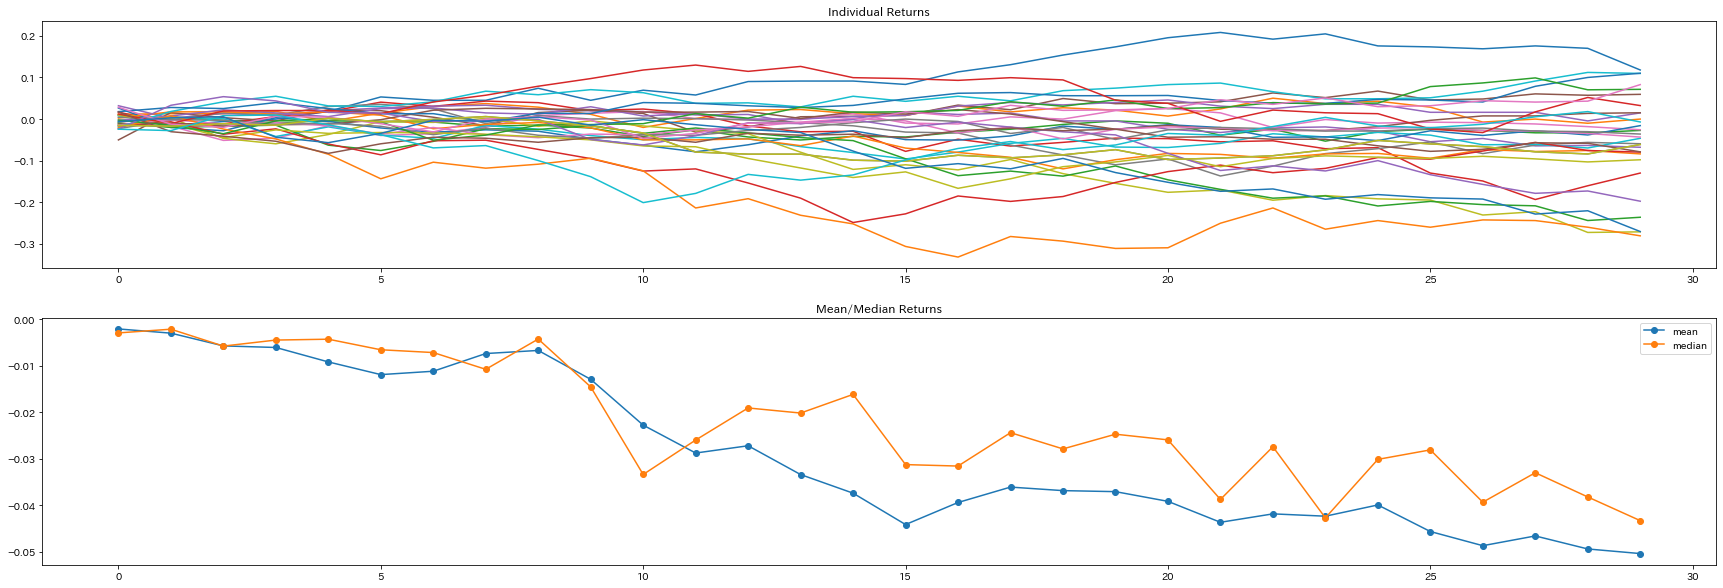

In [18]:
fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(2, 1, 1)   #２行１列の１番目
for code in dict_target_change.keys():
    ax1.plot(dict_target_change[code][1][:30])
ax1.set_title("Individual Returns")

ax2 = fig.add_subplot(2, 1, 2)   #２行１列の２番目
ax2.plot(
    np.mean([dict_target_change[code][1][:30] for code in dict_target_change.keys()],axis=0),
    marker='o',
    label="mean"
)
ax2.plot(
    np.median([dict_target_change[code][1][:30] for code in dict_target_change.keys()],axis=0),
    marker='o',
    label="median"
)
ax2.set_title("Mean/Median Returns")
plt.legend()
plt.show()

ここまでは前回の復習

In [19]:
# 仮説をたてるところまで　visualyzation.pyへの引数、codeごとの値を辞書化　

dict_target_change_ipo = {}
for code in df_first[df_first["時価総額_公募価格（円）"] >= 500 * 10000**2].index:
    df_ipo = df_first.loc[code]
    df_ipo
    dt_ipo, dt_get_ipo = df_ipo[["上場日", "当選発表日"]]
    df_mothers_price_30days = df_mothers_price.loc[
        (df_mothers_price.Date <= dt_ipo + datetime.timedelta(days=50))
        & (df_mothers_price.Date >= dt_ipo)
    ]
    if len(df_mothers_price_30days) == 0:
        continue
    df_mothers_price_30days = df_mothers_price_30days.reset_index(drop=True)
    
    # 個別ipo銘柄の値動き
    df_ipo_price_ba30days = jqapi.get_prices_daily_quotes(code=code)
    df_ipo_price_ba30days = df_ipo_price_ba30days.fillna(method='ffill')


    df_ipo_price_ba30days = df_ipo_price_ba30days.loc[
        (df_ipo_price_ba30days.Date <= dt_ipo + datetime.timedelta(days=50))
    ]
    df_ipo_price_ba30days = df_ipo_price_ba30days.reset_index(drop=True)
    # もし上場日寄り付かなかった場合の処理
    # 1行目がNaNであるかどうかを確認する
    while pd.isna(df_ipo_price_ba30days.iloc[0]['Close']):
        # 1行目がNaNである場合、1行目を削除する
        df_ipo_price_ba30days = df_ipo_price_ba30days.drop(0)
        # df_ipo_price_ba30days = df_ipo_price_ba30days.reset_index(drop=True)

        df_mothers_price_30days = df_mothers_price_30days.drop(0)
        # df_mothers_price_30days = df_mothers_price_30days.reset_index(drop=True)
    # 日付start作成
    ipo_start = dt_ipo

    # 日付end作成
    ipo_end = dt_ipo + datetime.timedelta(days=60)



    dict_target_change_ipo[code] = (
        df_mothers_price_30days,
        df_ipo_price_ba30days,
        ipo_start,
        ipo_end
    )

    

複数銘柄可視化の機能作成　02/16～

In [20]:
# 2/22 1130
# visualyzation.pyの修正前の実験用コード　okならコピペする
def multiplot_matplotlib(df_list, day_period=30, is_plot_mean=False, is_plot_mean_alpha=0.3, log_y=False, log_y_base=10, log_y_linthresh=10.0):
    """
    複数の株価チャートを表示する
    :param df_list: list of DataFrame 株価データを含むDataFrameのリスト
    :param day_period: int イベント日からの日数
    :param is_plot_mean: bool 銘柄群平均騰落率をplotするかどうか
    :param is_plot_mean_alpha: int is_plot_meanのplotの濃さ
    :param log_y: bool y軸をlog表示にする
    :param log_y_base: float 対数の底の値
    :param log_y_linthresh: float 対数スケールを線形スケールに変更する値。0からどこまでを線形スケールにするか範囲を設定。値が小さいほど0付近の動きが大きくなる。
    :return: 複数銘柄のチャート
    """
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    # 複数の株価を同じグラフにプロット
    for i, df in enumerate(df_list):
        # jpxのdateカラムはDateのため変換
        if "date" not in df.columns:
            df = df.rename(
                columns={
                    f"Adjustment{c}": f"fix_{c.lower()}"
                    for c in ["Open", "High", "Low", "Close"]
                }
            )
            df = df.rename(columns={"Date": "date", "Code": "CODE"})
        # インデックスをリセット
        df = df.reset_index(drop=True)
        # 表示する期間を制限
        df = df.iloc[:day_period]
        # 元のdfにも反映させる
        df_list[i] = df
        # 騰落率の計算
        returns = (df["fix_close"] / df["fix_open"].iloc[0] - 1) * 100
        # グラフの描画
        if is_plot_mean:
            ax.plot(df.index, returns, alpha=is_plot_mean_alpha, label=df["CODE"].iloc[0])
        else:
            ax.plot(df.index, returns, alpha=1.0, label=df["CODE"].iloc[0])
    if is_plot_mean:
        # 全体の騰落率の平均値を求める
        all_returns = [returns for df in df_list for returns in (df["fix_close"] / df["fix_open"].iloc[0] - 1) * 100]
        # 各日の騰落率の平均値を求める
        mean_daily_returns = [np.mean([all_returns[i] for i in range(len(all_returns)) if i % day_period == j]) for j in range(day_period)]
        # 全体の騰落率の平均値をプロット
        ax.plot(mean_daily_returns, label="Mean Returns", color='red')
    # グラフのラベルとタイトルを設定
    ax.set_xlabel("Date")
    ax.set_ylabel("Returns (%)")
    ax.set_title("Price Returns")
    # 凡例を表示
    fig.legend()
    fig.subplots_adjust(right=0.8)
    # y軸を対数表示
    if log_y:
        ax.set_yscale("symlog", base=log_y_base, linthresh=log_y_linthresh)
        ax.set_ylabel("Log Returns (%)")
    # グラフを表示
    plt.show()

In [21]:
# 2/23 1000 0起点で開始するように修正
# # visualyzation.pyの修正前の実験用コード　okならコピペする
def multiplot_matplotlib(df_list, day_period=30, is_plot_mean=False, is_plot_mean_alpha=0.3, log_y=False, log_y_base=10, log_y_linthresh=10.0):
    """
    複数の株価チャートを表示する
    :param df_list: list of DataFrame 株価データを含むDataFrameのリスト
    :param day_period: int イベント日からの日数
    :param is_plot_mean: bool 銘柄群平均騰落率をplotするかどうか
    :param is_plot_mean_alpha: int is_plot_meanのplotの濃さ
    :param log_y: bool y軸をlog表示にする
    :param log_y_base: float 対数の底の値
    :param log_y_linthresh: float 対数スケールを線形スケールに変更する値。0からどこまでを線形スケールにするか範囲を設定。値が小さいほど0付近の動きが大きくなる。
    :return: 複数銘柄のチャート
    """
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    # 複数の株価を同じグラフにプロット
    for i, df in enumerate(df_list):
        # jpxのdateカラムはDateのため変換
        if "date" not in df.columns:
            df = df.rename(
                columns={
                    f"Adjustment{c}": f"fix_{c.lower()}"
                    for c in ["Open", "High", "Low", "Close"]
                }
            )
            df = df.rename(columns={"Date": "date", "Code": "CODE"})
        # インデックスをリセット
        df = df.reset_index(drop=True)
        # 表示する期間を制限
        df = df.iloc[:day_period]
        # 元のdfにも反映させる
        df_list[i] = df
        # 騰落率の計算
        returns = (df["fix_close"] / df["fix_open"].iloc[0] - 1) * 100
        # 0から開始するため最初の行に0を追加して
        returns = pd.Series([0]).append(returns, ignore_index=True)
        # 0から始めるためindexの数を一つ増やす
        x_index_values = df.index.values
        x_index_values = np.append(x_index_values, x_index_values[-1] + 1)
        # グラフの描画
        if is_plot_mean:
            ax.plot(x_index_values, returns, alpha=is_plot_mean_alpha, label=df["CODE"].iloc[0])
        else:
            ax.plot(x_index_values, returns, alpha=1.0, label=df["CODE"].iloc[0])
    if is_plot_mean:
        # 全体の騰落率の平均値を求める
        all_returns = [returns for df in df_list for returns in (df["fix_close"] / df["fix_open"].iloc[0] - 1) * 100]
        # 各日の騰落率の平均値を求める
        mean_daily_returns = [np.mean([all_returns[i] for i in range(len(all_returns)) if i % day_period == j]) for j in range(day_period)]
        # 0から始まるようにする
        mean_daily_returns.insert(0, 0)
        # 全体の騰落率の平均値をプロット
        ax.plot(mean_daily_returns, label="Mean Returns", color='red')
    # グラフのラベルとタイトルを設定
    ax.set_xlabel("Date")
    ax.set_ylabel("Returns (%)")
    ax.set_title("Price Returns")
    # 凡例を表示
    fig.legend()
    fig.subplots_adjust(right=0.8)
    # y軸を対数表示
    if log_y:
        ax.set_yscale("symlog", base=log_y_base, linthresh=log_y_linthresh)
        ax.set_ylabel("Log Returns (%)")
    # グラフを表示
    plt.show()

In [22]:
# 2/23 1300 0起点で開始するように修正
# # visualyzation.pyの修正前の実験用コード　okならコピペする
def multiplot_matplotlib(df_list, day_period=30, is_plot_mean=False, is_plot_mean_alpha=0.3, log_y=False, log_y_base=10, log_y_linthresh=10.0):
    """
    複数の株価チャートを表示する
    :param df_list: list of DataFrame 株価データを含むDataFrameのリスト
    :param day_period: int イベント日からの日数
    :param is_plot_mean: bool 銘柄群平均騰落率をplotするかどうか
    :param is_plot_mean_alpha: int is_plot_meanのplotの濃さ
    :param log_y: bool y軸をlog表示にする
    :param log_y_base: float 対数の底の値
    :param log_y_linthresh: float 対数スケールを線形スケールに変更する値。0からどこまでを線形スケールにするか範囲を設定。値が小さいほど0付近の動きが大きくなる。
    :return: 複数銘柄のチャート
    """
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    # 複数の株価を同じグラフにプロット
    for i, df in enumerate(df_list):
        # jpxのdateカラムはDateのため変換
        if "date" not in df.columns:
            df = df.rename(
                columns={
                    f"Adjustment{c}": f"fix_{c.lower()}"
                    for c in ["Open", "High", "Low", "Close"]
                }
            )
            df = df.rename(columns={"Date": "date", "Code": "CODE"})
        # インデックスをリセット
        df = df.reset_index(drop=True)
        # 表示する期間を制限
        df = df.iloc[:day_period]
        # 元のdfにも反映させる
        df_list[i] = df
        # 騰落率の計算
        returns = (df["fix_close"] / df["fix_open"].iloc[0] - 1) * 100
        # 0から開始するため最初の行に0を追加して
        returns = pd.Series([0]).append(returns, ignore_index=True)
        # 0から始めるためindexの数を一つ増やす
        x_index_values = df.index.values
        x_index_values = np.append(x_index_values, x_index_values[-1] + 1)
        # グラフの描画
        if is_plot_mean:
            ax.plot(x_index_values, returns, marker='.', alpha=is_plot_mean_alpha, label=df["CODE"].iloc[0])
        else:
            ax.plot(x_index_values, returns, marker='.', alpha=1.0, label=df["CODE"].iloc[0])
    if is_plot_mean:
        # 全体の騰落率の平均値を求める
        all_returns = [returns for df in df_list for returns in (df["fix_close"] / df["fix_open"].iloc[0] - 1) * 100]
        # 各日の騰落率の平均値を求める
        mean_daily_returns = [np.mean([all_returns[i] for i in range(len(all_returns)) if i % day_period == j]) for j in range(day_period)]
        # 0から始まるようにする
        mean_daily_returns.insert(0, 0)
        # 全体の騰落率の平均値をプロット
        ax.plot(mean_daily_returns, marker='.', label="Mean Returns", color='red')
    # グラフのラベルとタイトルを設定
    ax.set_xlabel("Date")
    ax.set_ylabel("Returns (%)")
    ax.set_title("Price Returns")
    # 凡例を表示
    fig.legend()
    fig.subplots_adjust(right=0.8)
    # y軸を対数表示
    if log_y:
        ax.set_yscale("symlog", base=log_y_base, linthresh=log_y_linthresh)
        ax.set_ylabel("Log Returns (%)")
    # グラフを表示
    plt.show()

In [23]:
vi = vi()

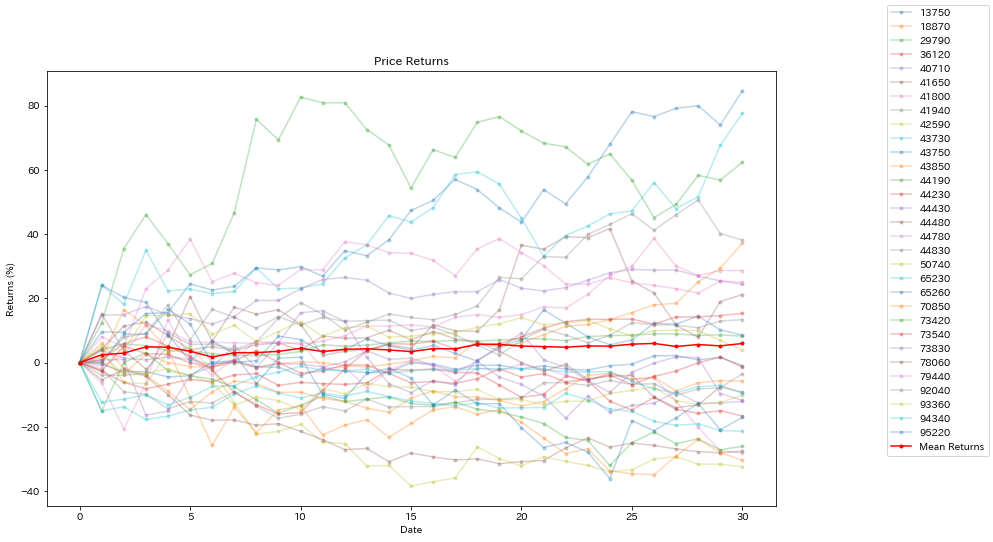

In [24]:
# is_plot_mean
df_list = [dict_target_change_ipo[code][1] for code in dict_target_change_ipo.keys()] 
vi.multiplot_matplotlib(df_list, day_period=30, is_plot_mean=True, is_plot_mean_alpha=0.3, log_y=False, log_y_base=10, log_y_linthresh=10.0)  # 複数のチャートを表示する

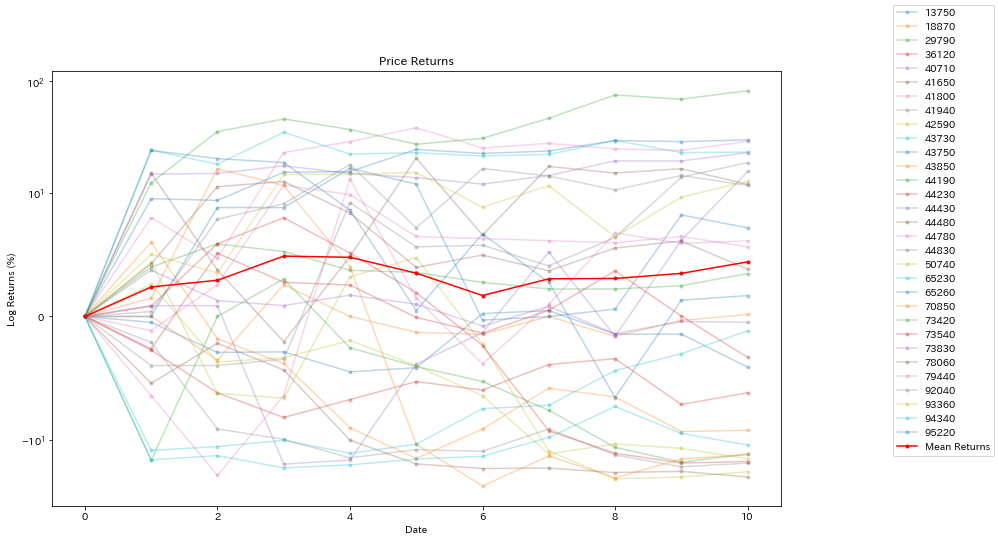

In [28]:
# is_plot_mean (log表示)
df_list = [dict_target_change_ipo[code][1] for code in dict_target_change_ipo.keys()] 
vi.multiplot_matplotlib(df_list, day_period=10, is_plot_mean=True, is_plot_mean_alpha=0.3, log_y=True, log_y_base=10, log_y_linthresh=10.0)  # 複数のチャートを表示する

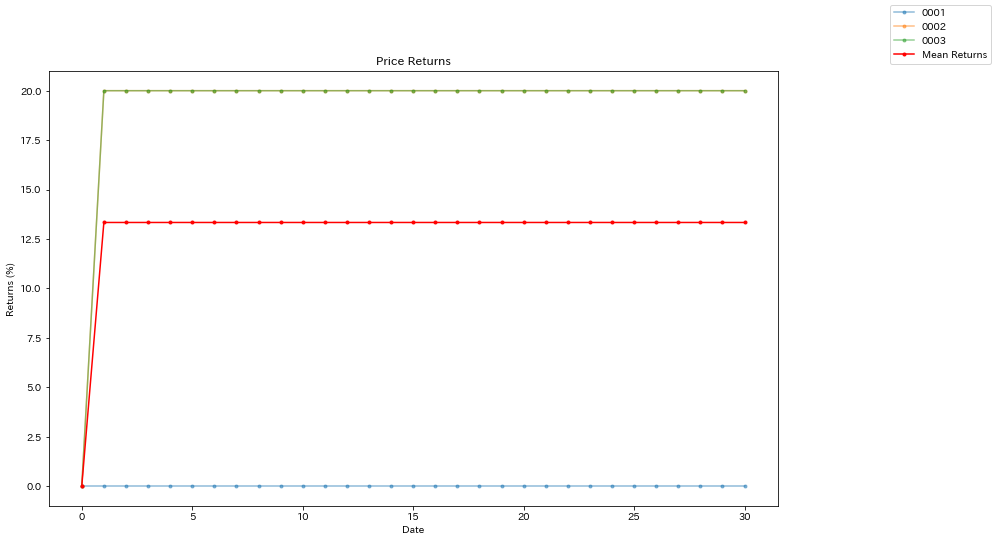

In [26]:
# 動作チェック用コード multiplot_matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ダミーデータの生成
df1 = pd.DataFrame({'date': pd.date_range('2022-01-01', periods=60, freq='D'),
                    'fix_open': np.random.randint(200, 201, 60),
                    'fix_close': np.random.randint(200, 201, 60),
                    "CODE" : "0001"})
df2 = pd.DataFrame({'date': pd.date_range('2022-01-01', periods=60, freq='D'),
                    'fix_open': np.random.randint(200, 201, 60),
                    'fix_close': np.random.randint(240, 241, 60),
                    "CODE" : "0002"})
df3 = pd.DataFrame({'date': pd.date_range('2022-01-01', periods=60, freq='D'),
                    'fix_open': np.random.randint(200, 201, 60),
                    'fix_close': np.random.randint(240, 241, 60),
                    "CODE" : "0003"})

# グラフの表示
multiplot_matplotlib([df1, df2,df3], day_period=30, is_plot_mean=True, is_plot_mean_alpha=0.5, log_y=False, log_y_base=10)


In [27]:
for code in dict_target_change_ipo.keys():
    print(code)
    # strftimeで文字列型に変換して、int()関数で変換
    start = dict_target_change_ipo[code][2].strftime('%Y%m%d')
    end = dict_target_change_ipo[code][3].strftime('%Y%m%d')
    vi().pairchart(dict_target_change_ipo[code][0],dict_target_change_ipo[code][1],start,end,indexing=True)
    # df確認用　下2行
    # print(dict_target_change_ipo[code][0])
    # print(dict_target_change_ipo[code][1])

1375


TypeError: 'visualization' object is not callable